<a href="https://colab.research.google.com/github/edeery3/Stock_prediction/blob/main/BAE_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Preprocessing

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [4]:
bae = pd.read_excel('/Stockdataset.xlsx', engine = 'openpyxl', sheet_name = 'bae')

In [5]:
def convert_volume(val):
    val = str(val).strip().upper()
    if 'M' in val:
        return float(val.replace('M', '')) * 1000000
    elif 'K' in val:
        return float(val.replace('K', '')) * 1000
    elif val.replace('.', '', 1).isdigit():
        return float(val)
    else:
        return 0

In [6]:
bae.isnull().sum()

,0
Date,0
Price,0
Open,0
High,0
Low,0
Vol.,1
Change %,0


In [7]:
bae['Vol.'] = bae['Vol.'].apply(convert_volume)

In [8]:
bae.drop('Date', axis = 1).describe()

,Price,Open,High,Low,Vol.,Change %
count,2527.000000,2527.000000,2527.000000,2527.000000,2.527000e+03,2527.000000
mean,701.721963,701.748397,708.726620,694.481634,7.274212e+06,0.000553
std,273.885135,273.881607,276.854746,270.576527,3.934452e+06,0.015162
min,397.000000,398.600000,406.400000,395.900000,0.000000e+00,-0.081100
25%,511.000000,511.100000,516.865000,505.900000,4.860000e+06,-0.006950
50%,583.500000,583.000000,588.600000,579.600000,6.460000e+06,0.000800
75%,806.500000,804.200000,814.800000,796.465000,8.685000e+06,0.008100
max,1673.000000,1671.500000,1708.000000,1649.500000,5.350000e+07,0.145800


In [9]:
bae['SMA_30'] = bae['Price'].rolling(window=30).mean()
bae['Volatility_20'] = bae['Price'].rolling(window=20).std()


In [10]:
bae['Date'] = pd.to_datetime(bae['Date'])
bae.set_index('Date', inplace=True)
bae.sort_index(inplace=True)

In [11]:
train_start = '2015-04-01'
train_end = '2023-04-01'

# Use index-based slicing
train_bae = bae[train_start:train_end]
test_bae = bae[train_end:]

print(f"Train size: {len(train_bae)}, Test size: {len(test_bae)}")


Train size: 2022, Test size: 505


Exploratory Data Analysis

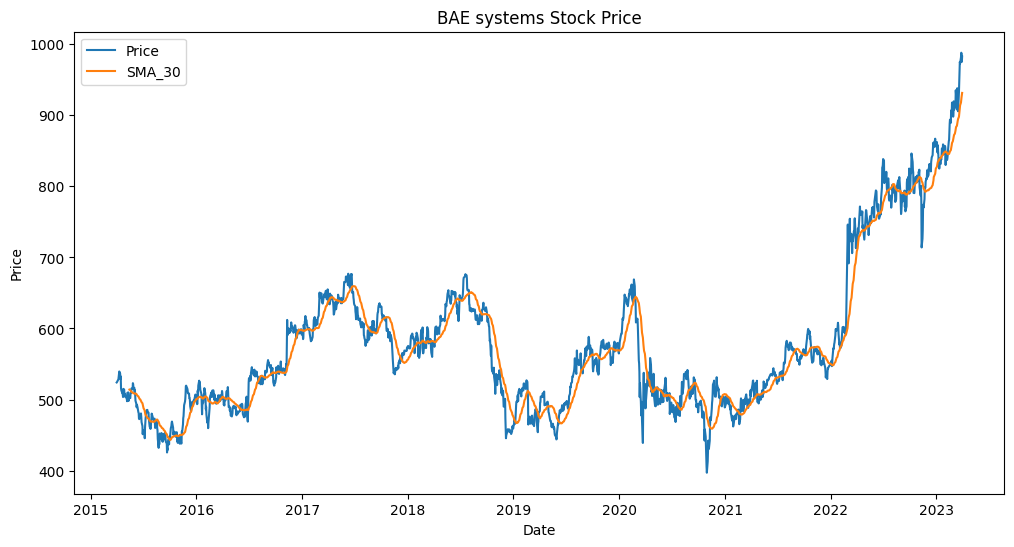

In [12]:
plt.figure(figsize = (12,6))
plt.plot(train_bae['Price'])
plt.plot(train_bae['SMA_30'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('BAE systems Stock Price')
plt.legend(['Price', 'SMA_30'])
plt.show()

In [13]:
fig = go.Figure(data=[go.Candlestick(
    open=train_bae['Open'],
    high=train_bae['High'],
    low=train_bae['Low'],
    close=train_bae['Price'],
    increasing_line_color='green',
    decreasing_line_color='red'
)])

fig.update_layout(title='BAE systems Candlestick Chart', xaxis_title='Date', yaxis_title='Price')
fig.show()

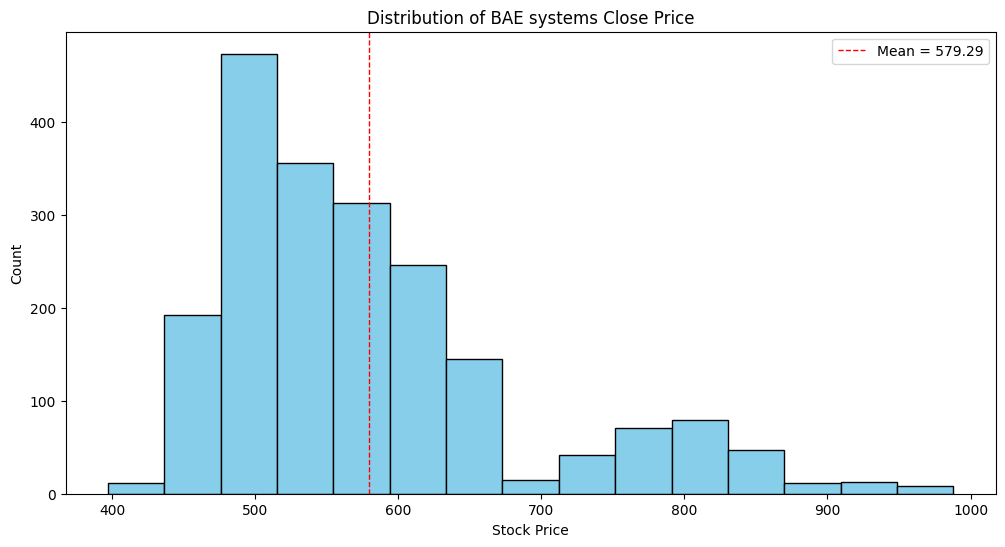

In [14]:
bae_mean = np.mean(train_bae['Price'])

plt.figure(figsize = (12,6))
plt.hist(train_bae['Price'], bins = 15, lw = 2, edgecolor = 'black', color = 'skyblue')
plt.xlabel('Stock Price')
plt.ylabel('Count')
plt.title('Distribution of BAE systems Close Price')
plt.axvline(bae_mean,  color='red', linestyle='--', linewidth=1, label=f'Mean = {bae_mean:.2f}')
plt.legend()

ARIMA

In [15]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error
from scipy.stats import skew, kurtosis
import statsmodels.api as sm

In [16]:
train_close = train_bae['Price']
test_close = test_bae['Price']

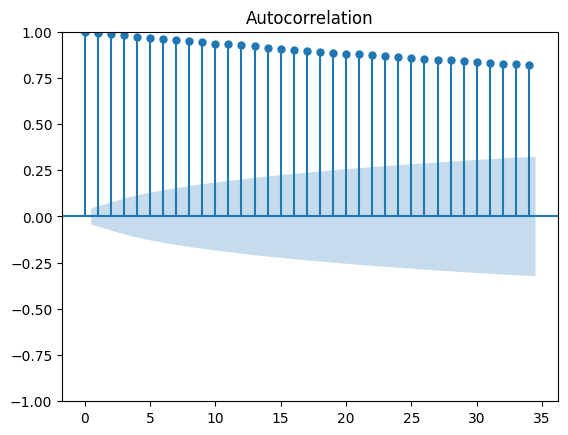

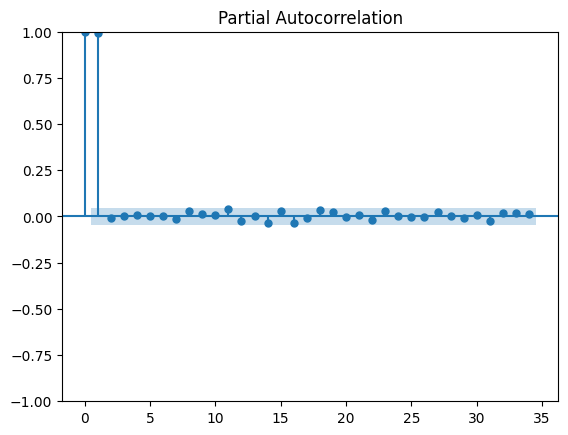

In [17]:
plot_acf(train_close)
plot_pacf(train_close)
plt.show()

In [18]:
result = adfuller(train_close)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: 0.15791258683633955
p-value: 0.9697997526116952


In [19]:
train_close = train_close.asfreq(pd.infer_freq(train_close.index))
train_close = train_close.interpolate(method='linear')

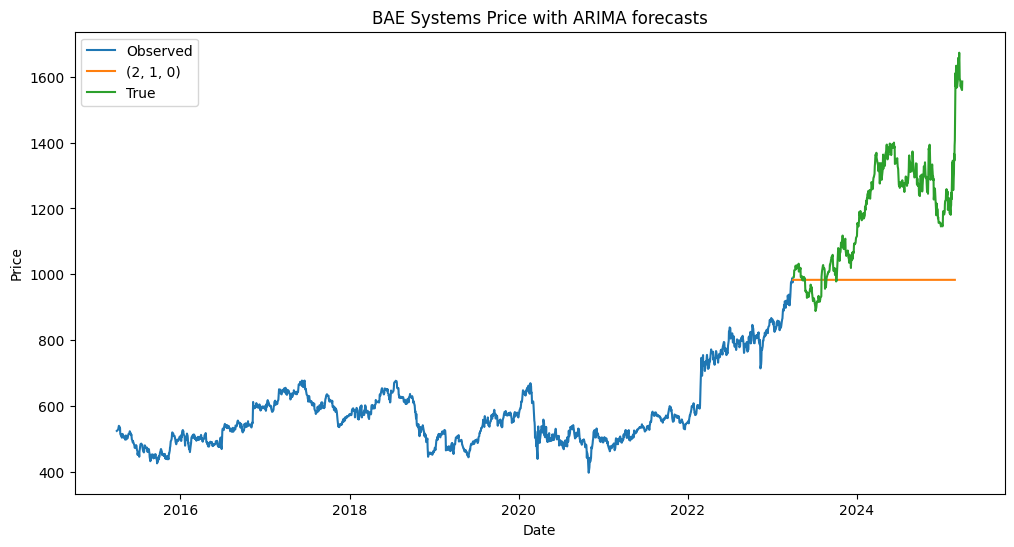

In [20]:
# ARIMA fit
model = ARIMA(train_close, order=(2, 1, 0))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=700)

# Plot
plt.figure(figsize = (12,6))
plt.plot(train_close, label = 'Observed')
plt.plot(forecast, label = '(2, 1, 0)')
plt.plot(test_close, label = 'True')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('BAE Systems Price with ARIMA forecasts')
plt.legend()
plt.show()

In [21]:
results_list = []

for p in range(6):
    for d in range(3):
        for q in range(6):
                model = ARIMA(train_close, order=(p, d, q))
                fitted = model.fit()

                # Residuals and in-sample predictions
                resid = fitted.resid
                insample_pred = fitted.fittedvalues
                insample_actual = train_close[-len(insample_pred):]
                rmse_insample = np.sqrt(mean_squared_error(insample_actual, insample_pred))

                # Forecast on test set
                forecast = fitted.forecast(steps=len(test_close))
                rmse_outsample = np.sqrt(mean_squared_error(test_close, forecast))

                # AIC and BIC
                aic = fitted.aic
                bic = fitted.bic

                # Residual diagnostics
                if len(resid) > 10:
                    ljung_box_p = acorr_ljungbox(resid, lags=[10], return_df=True)['lb_pvalue'].iloc[0]
                    res_skew = skew(resid)
                    res_kurt = kurtosis(resid)
                else:
                    ljung_box_p = np.nan
                    res_skew = np.nan
                    res_kurt = np.nan

                # Store results
                results_list.append({
                    'order': (p, d, q),
                    'AIC': aic,
                    'BIC': bic,
                    'RMSE_in': rmse_insample,
                    'RMSE_out': rmse_outsample,
                    'LjungBox_p': ljung_box_p,
                    'Skewness': res_skew,
                    'Kurtosis': res_kurt
                })


# Convert to DataFrame
results_df = pd.DataFrame(results_list)

# Sort by out-of-sample RMSE
results_df = results_df.sort_values(by='RMSE_out')


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-inve

In [22]:
results_df = results_df.sort_values(by='AIC', ascending= False).reset_index(drop=True)

results_df.head(50)

,order,AIC,BIC,RMSE_in,RMSE_out,LjungBox_p,Skewness,Kurtosis
0,"(0, 0, 0)",35630.335001,35642.295048,107.477959,635.601141,0.000000e+00,1.306113,1.278776
1,"(0, 0, 1)",31810.037282,31827.977353,55.864631,635.364281,0.000000e+00,1.288347,1.487629
2,"(0, 0, 2)",28827.854535,28851.774630,33.527292,635.111447,0.000000e+00,1.185607,1.743222
3,"(0, 0, 3)",26747.325624,26777.225742,23.484497,635.019411,0.000000e+00,1.066298,2.099200
4,"(0, 0, 5)",26312.025534,26353.885699,21.770397,634.786394,0.000000e+00,0.939472,2.050250
5,"(0, 0, 4)",25172.826809,25208.706950,17.941602,634.902411,0.000000e+00,1.068742,2.495282
6,"(0, 2, 0)",21130.691591,21136.670930,14.092676,1913.412339,2.951218e-113,15.394257,693.115017
7,"(1, 2, 0)",20343.511227,20355.469905,13.392481,163.609457,6.542463e-63,17.871756,849.666502
8,"(2, 2, 0)",20055.708279,20073.646296,13.171867,301.155428,4.425302e-52,18.784931,908.020734
9,"(3, 2, 0)",19950.523115,19974.440470,13.094775,247.567780,5.370887e-50,19.131689,929.595504


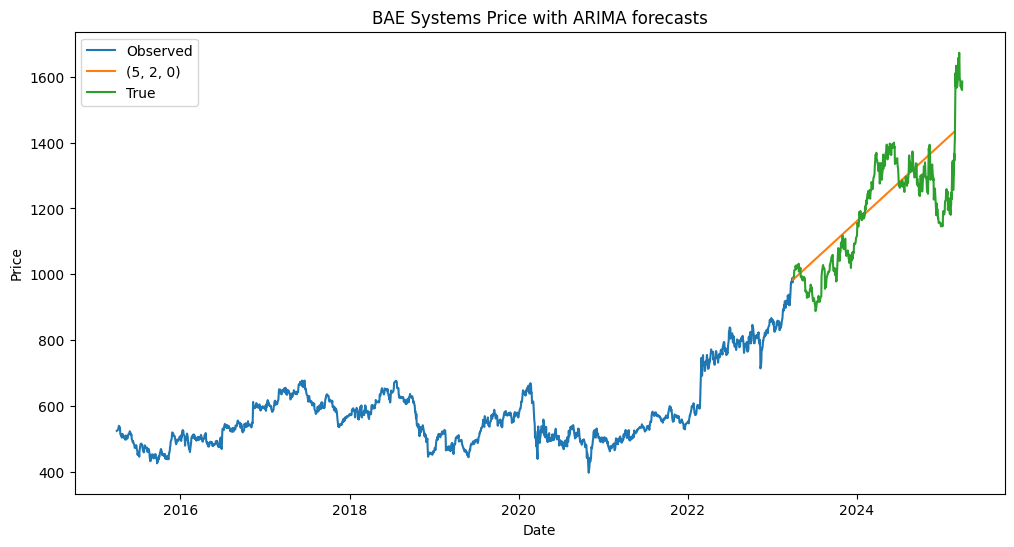

In [23]:
model = ARIMA(train_close, order=(5, 2, 0))
model_fit = model.fit()

forecast = model_fit.forecast(steps=700)

plt.figure(figsize = (12,6))
plt.plot(train_close, label = 'Observed')
plt.plot(forecast, label = '(5, 2, 0)')
plt.plot(test_close, label = 'True')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('BAE Systems Price with ARIMA forecasts')
plt.legend()
plt.show()

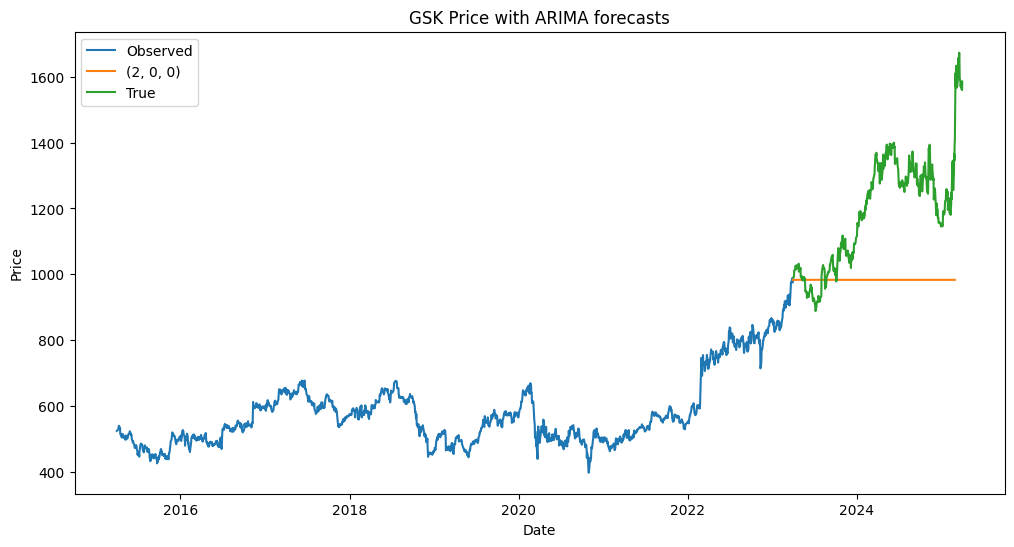

In [24]:
model = ARIMA(train_close, order=(5, 1, 2))
model_fit = model.fit()

forecast = model_fit.forecast(steps=700)

plt.figure(figsize = (12,6))
plt.plot(train_close, label = 'Observed')
plt.plot(forecast, label = '(2, 0, 0)')
plt.plot(test_close, label = 'True')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('GSK Price with ARIMA forecasts')
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



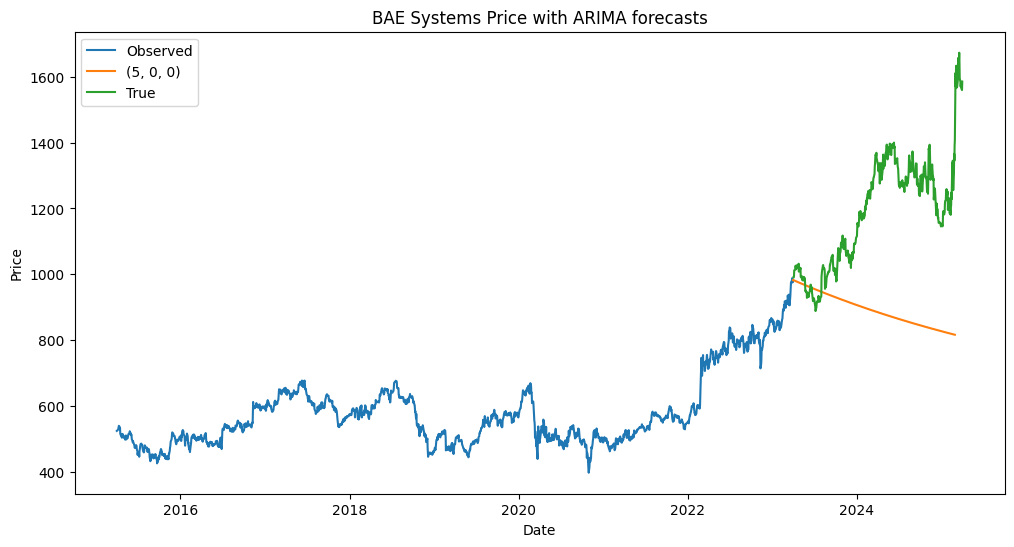

In [25]:
model = ARIMA(train_close, order=(5, 0, 0))
model_fit = model.fit()

forecast = model_fit.forecast(steps=700)

plt.figure(figsize = (12,6))
plt.plot(train_close, label = 'Observed')
plt.plot(forecast, label = '(5, 0, 0)')
plt.plot(test_close, label = 'True')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('BAE Systems Price with ARIMA forecasts')
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



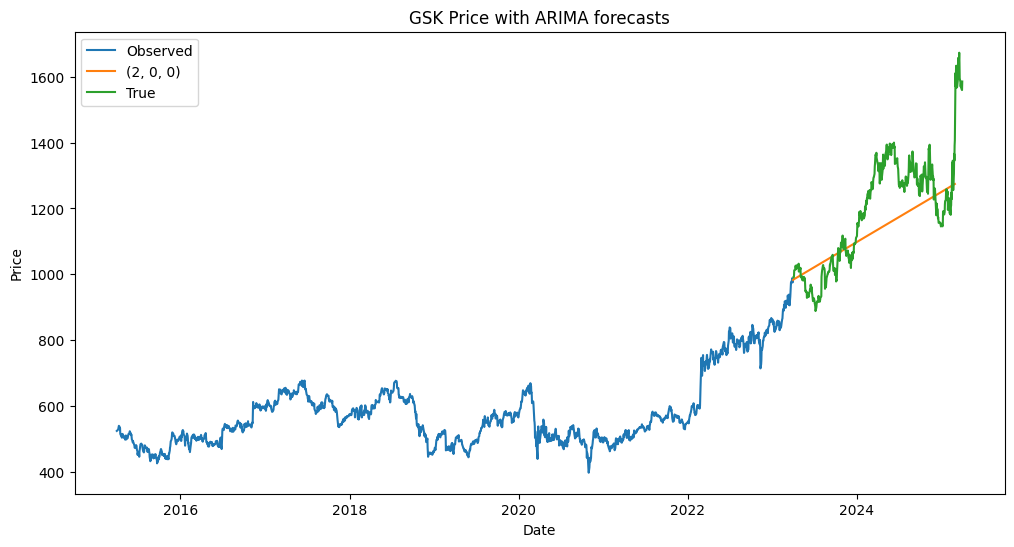

In [26]:
model = ARIMA(train_close, order=(0, 2, 5))
model_fit = model.fit()

forecast = model_fit.forecast(steps=700)

plt.figure(figsize = (12,6))
plt.plot(train_close, label = 'Observed')
plt.plot(forecast, label = '(2, 0, 0)')
plt.plot(test_close, label = 'True')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('GSK Price with ARIMA forecasts')
plt.legend()
plt.show()

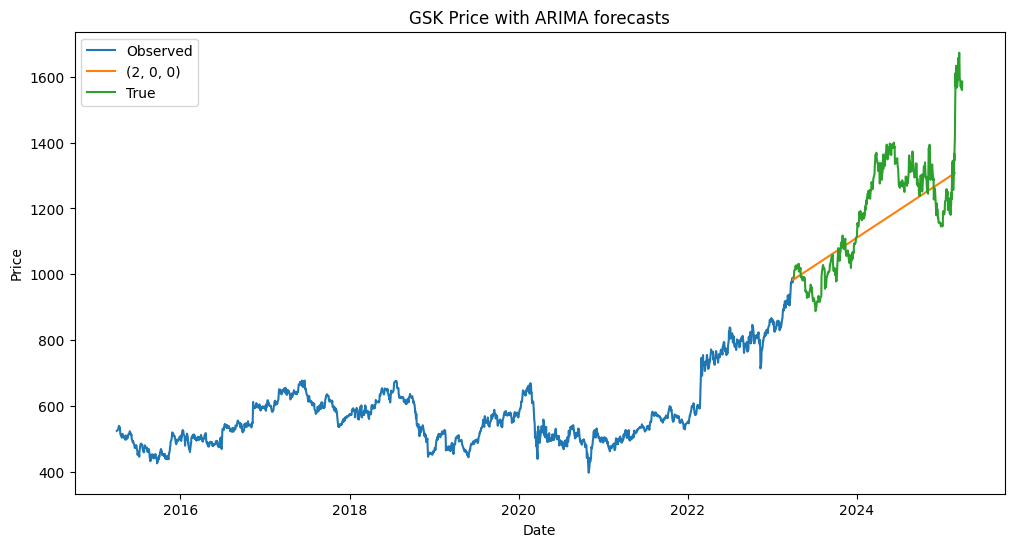

In [27]:
model = ARIMA(train_close, order=(3, 2, 3))
model_fit = model.fit()

forecast = model_fit.forecast(steps=700)

plt.figure(figsize = (12,6))
plt.plot(train_close, label = 'Observed')
plt.plot(forecast, label = '(2, 0, 0)')
plt.plot(test_close, label = 'True')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('GSK Price with ARIMA forecasts')
plt.legend()
plt.show()

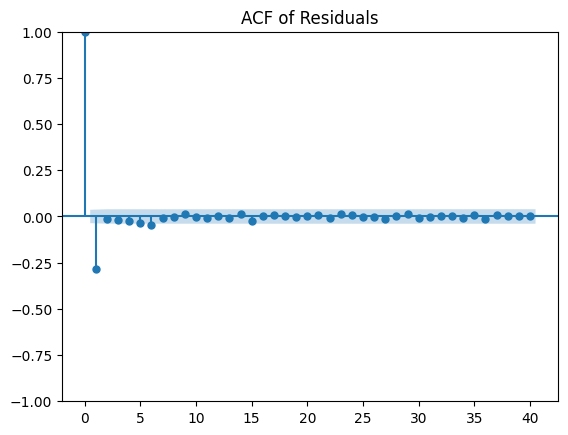

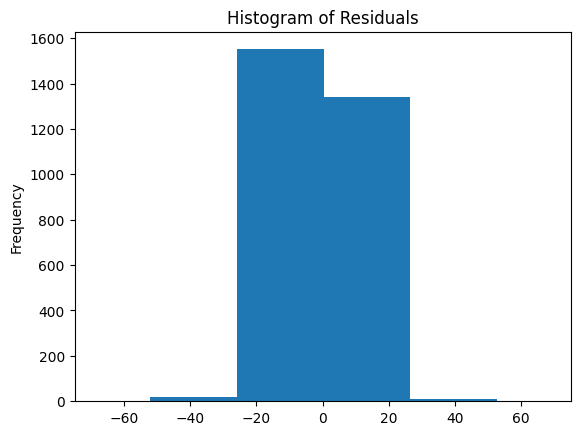

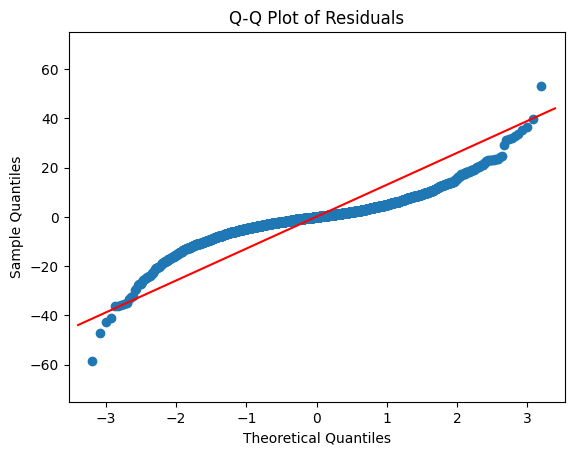

In [28]:
model = ARIMA(train_close, order=(5, 2, 0))
model_fit = model.fit()


residuals = model_fit.resid

# ACF plot
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.title("ACF of Residuals")
plt.show()

# Histogram
residuals.plot(kind='hist', bins=30, title='Histogram of Residuals')
plt.xlim(-75,75)
plt.show()

# Q-Q plot
sm.qqplot(residuals, line='s')
plt.title("Q-Q Plot of Residuals")
plt.ylim(-75,75)
plt.show()

Rolling Forecast (5-step) RMSE: 45.25


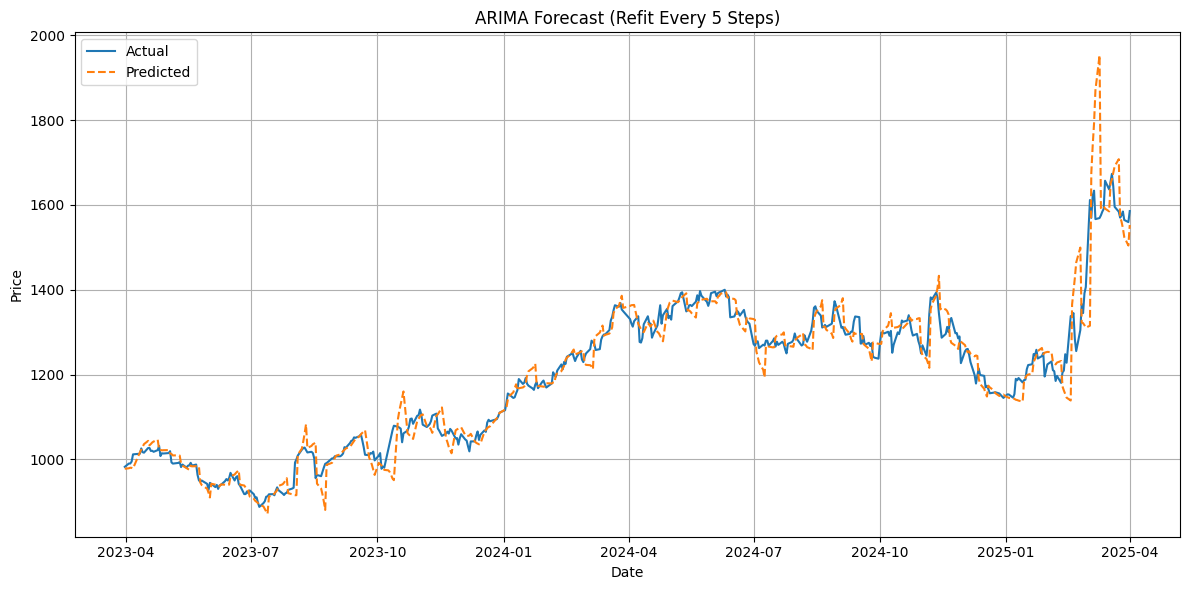

In [29]:
data = bae['Price'].values
dates = bae.index

# Train/Test split
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]
train_dates, test_dates = dates[:train_size], dates[train_size:]

# Initialize
history = list(train)
history_dates = list(train_dates)
predictions = []
predicted_dates = []

step = 5
t = 0

while t < len(test):
    rolling = ARIMA(history, order=(5, 2, 0))
    rolling_fit = rolling.fit()

    end = min(t + step, len(test))
    forecast = rolling_fit.forecast(steps=end - t)

    # Apply to dates
    predictions.extend(forecast)
    predicted_dates.extend(test_dates[t:end])


    history.extend(test[t:end])
    history_dates.extend(test_dates[t:end])

    t = end

# Evaluation
predictions = predictions[:len(test)]
predicted_dates = predicted_dates[:len(test)]
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f"Rolling Forecast (5-step) RMSE: {rmse:.2f}")

# Plot
plt.figure(figsize=(12,6))
plt.plot(test_dates, test, label='Actual')
plt.plot(predicted_dates, predictions, label='Predicted', linestyle='--')
plt.title("ARIMA Forecast (Refit Every 5 Steps)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

LSTM

Epoch 1/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - loss: 0.0157 - val_loss: 0.0293
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0026 - val_loss: 0.0593
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.0028 - val_loss: 0.0183
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0025 - val_loss: 0.0254
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0024 - val_loss: 0.0094
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0019 - val_loss: 0.0109
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - loss: 0.0017 - val_loss: 0.0237
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 0.0018 - val_loss: 0.0080
Epoch 9/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - loss: 0.0023 - val_loss: 0.0208
Epoch 10/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 0.0015 - val_loss: 0.0106
Epoch 11/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0014 - val_loss: 0.0120
Epoch 12/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.

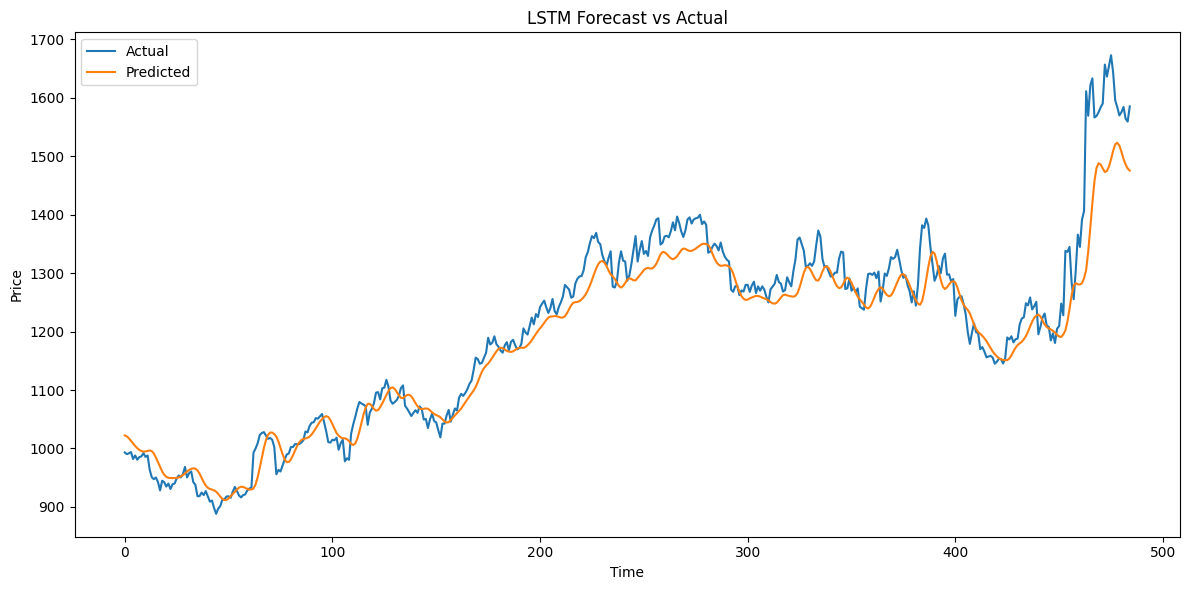

In [30]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping


# Scale the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_close.values.reshape(-1, 1))
test_scaled = scaler.transform(test_close.values.reshape(-1, 1))


def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i - n_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)


# Prepare sequences
n_steps = 20
X_train, y_train = create_sequences(train_scaled, n_steps)
X_test, y_test = create_sequences(test_scaled, n_steps)

# LSTM model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences = True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Predict
y_pred = model.predict(X_test)

# Inverse transform
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title("LSTM Forecast vs Actual")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()


In [31]:


mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

MAE: 31.14, RMSE: 46.38


Epoch 1/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - loss: 0.0246
Epoch 2/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.0026
Epoch 3/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - loss: 0.0022
Epoch 4/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - loss: 0.0021
Epoch 5/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 0.0019
Epoch 6/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - loss: 0.0019
Epoch 7/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 0.0019
Epoch 8/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - loss: 0.0016
Epoch 9/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - loss: 0.0015
Epoch 10/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 0.0016
Epoch 11/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - loss: 0.0013
Epoch 12/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - loss: 0.0013
Epoch 13/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 0.0013
Epoch 14/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - loss: 0.0011
Epoch 15/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.00

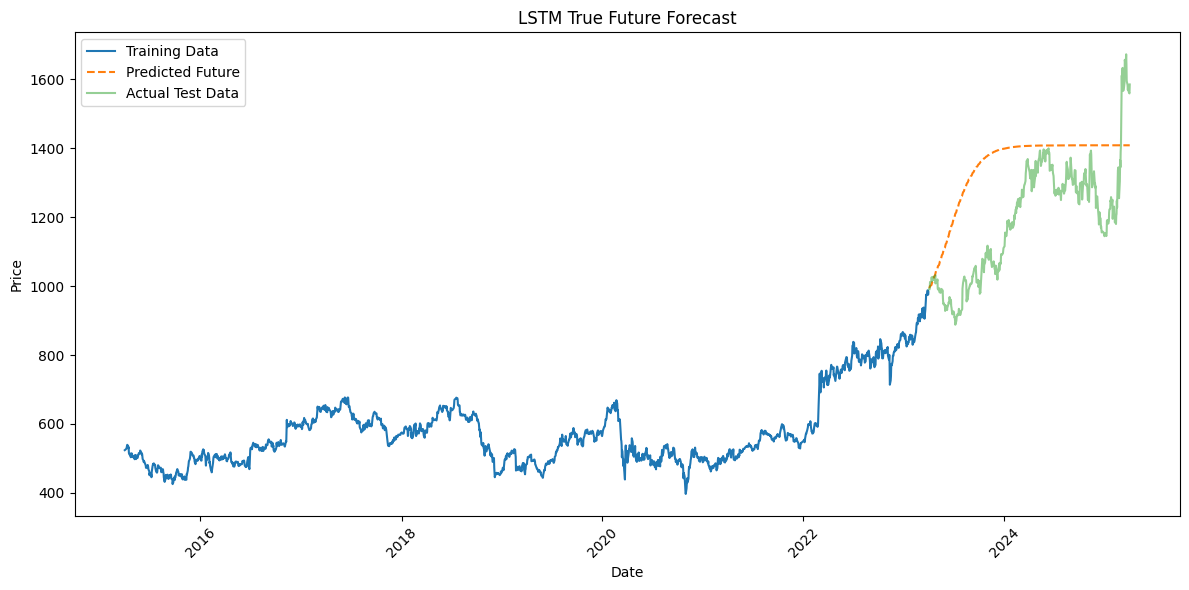

In [36]:



# Scale the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_close.values.reshape(-1, 1))
test_scaled = scaler.transform(test_close.values.reshape(-1, 1))



def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i - n_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

n_steps = 100
X_train, y_train = create_sequences(train_scaled, n_steps)

# LSTM model

model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences = True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Forecasting
def recursive_forecast(model, initial_sequence, n_steps_ahead):
    """
    Predicts n_steps_ahead values using the LSTM, recursively feeding predictions.
    """
    sequence = initial_sequence.copy()
    predictions = []

    for _ in range(n_steps_ahead):
        seq_reshaped = sequence.reshape((1, sequence.shape[0], sequence.shape[1]))
        pred_scaled = model.predict(seq_reshaped, verbose=0)
        pred = scaler.inverse_transform(pred_scaled)
        predictions.append(pred[0, 0])
        sequence = np.vstack((sequence[1:], pred_scaled))

    return np.array(predictions)


initial_seq = train_scaled[-n_steps:]
n_forecast = len(test_scaled)
future_preds = recursive_forecast(model, initial_seq, n_forecast)


all_dates = train_close.index.append(test_close.index)

plt.figure(figsize=(12,6))
plt.plot(train_close.index, train_close.values, label='Training Data')
plt.plot(test_close.index, future_preds, label='Predicted Future', linestyle='--')
plt.plot(test_close.index, test_close.values, label='Actual Test Data', alpha=0.5)
plt.title("LSTM True Future Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [37]:
# Flatten both arrays to 1D
y_true = test_close.values.flatten()
y_pred = future_preds.flatten()

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

MAE: 176.47, RMSE: 203.40
